In [133]:
import os
import csv
import librosa
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import random
import tensorflow as tf

import scipy.io as sio
from scipy.stats import skew
from scipy.stats import kurtosis

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)

In [134]:
sample_rate = 16000
desired_length = 8
n_mels = 64
nfft = 256
hop = nfft//2
f_max = 2000
stetho_id=-1
folds_file = './ICBHI_Dataset/patient_list_foldwise.txt'
# train_flag = train_flag

In [135]:
import pandas as pd
data_dir = './ICBHI_Dataset/audio_and_txt_files/'
# file_name = './Dataset/audio_and_txt_files/'
def Extract_Annotation_Data(file_name, data_dir):
	tokens = file_name.split('_')
	recording_info = pd.DataFrame(data = [tokens], columns = ['Patient Number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
	recording_annotations = pd.read_csv(os.path.join(data_dir, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
	return recording_info, recording_annotations

# get annotations data and filenames
def get_annotations(data_dir):
	filenames = [s.split('.')[0] for s in os.listdir(data_dir) if '.txt' in s]
	i_list = []
	rec_annotations_dict = {}
	for s in filenames:
		i,a = Extract_Annotation_Data(s, data_dir)
		i_list.append(i)
		rec_annotations_dict[s] = a

	recording_info = pd.concat(i_list, axis = 0)
	recording_info.head()

	return filenames, rec_annotations_dict



def slice_data(start, end, raw_data, sample_rate):
	max_ind = len(raw_data) 
	start_ind = min(int(start * sample_rate), max_ind)
	end_ind = min(int(end * sample_rate), max_ind)
	return raw_data[start_ind: end_ind]

def get_label(crackle, wheeze):
	if crackle == 0 and wheeze == 0:
		return 0
	elif crackle == 1 and wheeze == 0:
		return 1
	elif crackle == 0 and wheeze == 1:
		return 2
	else:
		return 3
    

In [136]:
def get_sound_samples(recording_annotations, file_name, data_dir, sample_rate):
	sample_data = [file_name]
	# load file with specified sample rate (also converts to mono)
	data, rate = librosa.load(os.path.join(data_dir, file_name+'.wav'), sr=sample_rate)
	#print("Sample Rate", rate)
	
	for i in range(len(recording_annotations.index)):
		row = recording_annotations.loc[i]
		start = row['Start']
		end = row['End']
		crackles = row['Crackles']
		wheezes = row['Wheezes']
		audio_chunk = slice_data(start, end, data, rate)
		sample_data.append((audio_chunk, start,end, get_label(crackles, wheezes)))
	return sample_data

In [137]:
filenames, rec_annotations_dict = get_annotations(data_dir)
print(rec_annotations_dict)

{'101_1b1_Al_sc_Meditron':      Start     End  Crackles  Wheezes
0    0.036   0.579         0        0
1    0.579   2.450         0        0
2    2.450   3.893         0        0
3    3.893   5.793         0        0
4    5.793   7.521         0        0
5    7.521   9.279         0        0
6    9.279  11.150         0        0
7   11.150  13.036         0        0
8   13.036  14.721         0        0
9   14.721  16.707         0        0
10  16.707  18.507         0        0
11  18.507  19.964         0        0, '101_1b1_Pr_sc_Meditron':      Start     End  Crackles  Wheezes
0    0.036   1.264         0        0
1    1.264   3.422         0        0
2    3.422   5.550         0        0
3    5.550   7.436         0        0
4    7.436   9.221         0        0
5    9.221  11.264         0        0
6   11.264  13.264         0        0
7   13.264  15.179         0        0
8   15.179  17.207         0        0
9   17.207  19.179         0        0
10  19.179  19.936         0      

In [138]:
from tqdm import tqdm
filenames_with_labels = []
print("Exracting Individual Cycles")
cycle_list = []
classwise_cycle_list = [[], [], [],[]]
for idx, file_name in tqdm(enumerate(filenames)):
    data = get_sound_samples(rec_annotations_dict[file_name], file_name, data_dir, sample_rate)
    # print('--------', data)
    cycles_with_labels = [(d[0], d[3], file_name, cycle_idx, d[3]) for cycle_idx, d in enumerate(data[1:])] #lable: d[3]
    # print('cycles_with_labels: ', cycles_with_labels)
    cycle_list.extend(cycles_with_labels)
    for cycle_idx, d in enumerate(cycles_with_labels):
        filenames_with_labels.append(file_name+'_'+str(d[3])+'_'+str(d[1]))
        classwise_cycle_list[d[1]].append(d)
print(len(cycle_list))
print(len(classwise_cycle_list))

Exracting Individual Cycles


920it [00:17, 52.55it/s]

6898
4


In [139]:
# =============================================================================
# Data augmentation
# =============================================================================
# augment normal
seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
tf.keras.utils.set_random_seed(seed_value)
scale = 1
aug_nos = scale*len(classwise_cycle_list[0]) - len(classwise_cycle_list[0])
for idx in range(aug_nos):
    # normal_i + normal_j
    i = random.randint(0, len(classwise_cycle_list[0])-1)
    j = random.randint(0, len(classwise_cycle_list[0])-1)
    normal_i = classwise_cycle_list[0][i]
    normal_j = classwise_cycle_list[0][j]
    new_sample = np.concatenate([normal_i[0], normal_j[0]])
    cycle_list.append((new_sample, 0, normal_i[2]+'-'+normal_j[2], idx, 1))
    filenames_with_labels.append(normal_i[2]+'-'+normal_j[2]+'_'+str(idx)+'_0')
    
# augment abnormal (crackle)
aug_nos = scale*len(classwise_cycle_list[0]) - len(classwise_cycle_list[1])
for idx in range(aug_nos):
    aug_prob = random.random()
    if aug_prob < 0.6:
        # crackle_i + crackle_j
        i = random.randint(0, len(classwise_cycle_list[1])-1)
        j = random.randint(0, len(classwise_cycle_list[1])-1)
        sample_i = classwise_cycle_list[1][i]
        sample_j = classwise_cycle_list[1][j]
    elif aug_prob >= 0.6 and aug_prob < 0.8:
        # crackle_i + normal_j
        i = random.randint(0, len(classwise_cycle_list[1])-1)
        j = random.randint(0, len(classwise_cycle_list[0])-1)
        sample_i = classwise_cycle_list[1][i]
        sample_j = classwise_cycle_list[0][j]
    else:
        # normal_i + crackle_j
        i = random.randint(0, len(classwise_cycle_list[0])-1)
        j = random.randint(0, len(classwise_cycle_list[1])-1)
        sample_i = classwise_cycle_list[0][i]
        sample_j = classwise_cycle_list[1][j]

    new_sample = np.concatenate([sample_i[0], sample_j[0]])
    cycle_list.append((new_sample, 1, sample_i[2]+'-'+sample_j[2], idx, 1))
    filenames_with_labels.append(sample_i[2]+'-'+sample_j[2]+'_'+str(idx)+'_1')

# augment abnormal (wheeze)
aug_nos = scale*len(classwise_cycle_list[0]) - len(classwise_cycle_list[2])
for idx in range(aug_nos):
    aug_prob = random.random()
    if aug_prob < 0.6:
        # wheeze_i + wheeze_j
        i = random.randint(0, len(classwise_cycle_list[2])-1)
        j = random.randint(0, len(classwise_cycle_list[2])-1)
        sample_i = classwise_cycle_list[2][i]
        sample_j = classwise_cycle_list[2][j]
    elif aug_prob >= 0.6 and aug_prob < 0.8:
        # wheeze_i + normal_j
        i = random.randint(0, len(classwise_cycle_list[2])-1)
        j = random.randint(0, len(classwise_cycle_list[0])-1)
        sample_i = classwise_cycle_list[2][i]
        sample_j = classwise_cycle_list[0][j]
    else:
        # normal_i + wheeze_j
        i = random.randint(0, len(classwise_cycle_list[0])-1)
        j = random.randint(0, len(classwise_cycle_list[2])-1)
        sample_i = classwise_cycle_list[0][i]
        sample_j = classwise_cycle_list[2][j]

    new_sample = np.concatenate([sample_i[0], sample_j[0]])
    cycle_list.append((new_sample, 2, sample_i[2]+'-'+sample_j[2], idx, 1))
    filenames_with_labels.append(sample_i[2]+'-'+sample_j[2]+'_'+str(idx)+'_2')


# augment abnormal (both)
aug_nos = scale*len(classwise_cycle_list[0]) - len(classwise_cycle_list[3])
for idx in range(aug_nos):
    aug_prob = random.random()
    if aug_prob < 0.5:
        # both_i + both_j
        i = random.randint(0, len(classwise_cycle_list[3])-1)
        j = random.randint(0, len(classwise_cycle_list[3])-1)
        sample_i = classwise_cycle_list[3][i]
        sample_j = classwise_cycle_list[3][j]
    elif aug_prob >= 0.5 and aug_prob < 0.7:
        # crackle_i + wheeze_j
        i = random.randint(0, len(classwise_cycle_list[1])-1)
        j = random.randint(0, len(classwise_cycle_list[2])-1)
        sample_i = classwise_cycle_list[1][i]
        sample_j = classwise_cycle_list[2][j]
    elif aug_prob >= 0.7 and aug_prob < 0.8:
        # wheeze_i + crackle_j
        i = random.randint(0, len(classwise_cycle_list[3])-1)
        j = random.randint(0, len(classwise_cycle_list[0])-1)
        sample_i = classwise_cycle_list[3][i]
        sample_j = classwise_cycle_list[0][j]
    elif aug_prob >= 0.8 and aug_prob < 0.9:
        # both_i + normal_j
        i = random.randint(0, len(classwise_cycle_list[3])-1)
        j = random.randint(0, len(classwise_cycle_list[0])-1)
        sample_i = classwise_cycle_list[3][i]
        sample_j = classwise_cycle_list[0][j]
    else:
        # normal_i + both_j
        i = random.randint(0, len(classwise_cycle_list[0])-1)
        j = random.randint(0, len(classwise_cycle_list[3])-1)
        sample_i = classwise_cycle_list[0][i]
        sample_j = classwise_cycle_list[3][j]

    new_sample = np.concatenate([sample_i[0], sample_j[0]])
    cycle_list.append((new_sample, 3, sample_i[2]+'-'+sample_j[2], idx, 1))
    filenames_with_labels.append(sample_i[2]+'-'+sample_j[2]+'_'+str(idx)+'_3')

print("len(cycle_list): ",len(cycle_list))


len(cycle_list):  14568


In [140]:
# =============================================================================
# Aligning to an 8-second duration
# =============================================================================
audio_data = [] # each sample is a tuple with id_0: audio_data, id_1: label, id_2: file_name, id_3: cycle id, id_4: aug id, id_5: split id
labels = []
desiredLength = 10
print('desiredLength*sample_rate: ', desiredLength*sample_rate)
output = []
for idx, sample in enumerate(cycle_list):
    # print(f'{idx}: {sample}')
    output_buffer_length = int(desiredLength*sample_rate)
    soundclip = sample[0].copy()
    # print('soundclip: ', soundclip)
    # d = soundclip[0:3]
    # b = np.concatenate((soundclip,d))
    # print('soundclip copy: ', b)
    n_samples = len(soundclip)
    # print('n_samples: ', n_samples)
    if n_samples < output_buffer_length: # shorter than 8sec
        t = output_buffer_length // n_samples
        # print('tttt', t)
        if output_buffer_length % n_samples == 0: # repeat sample
            repeat_sample = np.tile(soundclip, t)
            copy_repeat_sample = repeat_sample.copy()
            output.append((copy_repeat_sample, sample[1]))
        else: 
            d = output_buffer_length % n_samples
            # print('ddddd', d)
            d = soundclip[:d] # remainder
            # print('dddddddd: ', d)
            # print('soundclip*t:', len(np.tile(soundclip, t)), n_samples*t)
            repeat_sample = np.concatenate((np.tile(soundclip, t), d))
            copy_repeat_sample = repeat_sample.copy()
            # print('copy_repeat_sample:', len(copy_repeat_sample))
            output.append((copy_repeat_sample, sample[1]))
    else:  # longer than 8sec
        copy_repeat_sample = soundclip[:output_buffer_length]
        output.append((copy_repeat_sample, sample[1]))
print('----Len Output-----', len(output))        
# print('----Output-----', output[1][1])
audio_data.extend(output)
print('len audio data: ', len(audio_data))

desiredLength*sample_rate:  160000
----Len Output----- 14568
len audio data:  14568


In [33]:
import cv2
import cmapy
def create_mel_raw(current_window, sample_rate, n_mels=128, f_min=50, f_max=4000, nfft=2048, hop=512, resz=1):
	S = librosa.feature.melspectrogram(y=current_window, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
	S = librosa.power_to_db(S, ref=np.max)
	S = (S-S.min()) / (S.max() - S.min())
	S *= 255
	img = cv2.applyColorMap(S.astype(np.uint8), cmapy.cmap('magma'))
	height, width, _ = img.shape
	if resz > 0:
		img = cv2.resize(img, (width*resz, height*resz), interpolation=cv2.INTER_LINEAR)
	img = cv2.flip(img, 0)
	return img


In [141]:
# =============================================================================
# compute_14_features
# =============================================================================
def compute_14_features(region):
    """ Compute 14 features """
    temp_array=region.reshape(-1)
    all_pixels=temp_array[temp_array!=0]
#    Area
    Area = np.sum(all_pixels)
#    mean
    density = np.mean(all_pixels)
#   Std
    std_Density = np.std(all_pixels)
#   skewness
    Skewness = skew(all_pixels)
#   kurtosis
    Kurtosis = kurtosis(all_pixels)
#   Energy
    ENERGY =np.sum(np.square(all_pixels))
#   Entropy
    value,counts = np.unique(all_pixels, return_counts=True)
    p = counts / np.sum(counts)
    p =  p[p!=0]
    ENTROPY =-np.sum( p*np.log2(p))
#   Maximum
    MAX = np.max(all_pixels)
#   Mean Absolute Deviation
    sum_deviation= np.sum(np.abs(all_pixels-np.mean(all_pixels)))
    mean_absolute_deviation = sum_deviation/len(all_pixels)
#   Median
    MEDIAN = np.median(all_pixels)
#   Minimum
    MIN = np.min(all_pixels)
#   Range
    RANGE = np.max(all_pixels)-np.min(all_pixels)
#   Root Mean Square
    RMS = np.sqrt(np.mean(np.square(all_pixels))) 
#    Uniformity
    UNIFORMITY = np.sum(np.square(p))

    features = np.array([Area, density, std_Density,
        Skewness, Kurtosis,ENERGY, ENTROPY,
        MAX, mean_absolute_deviation, MEDIAN, MIN, RANGE, RMS, UNIFORMITY])
    return features


In [142]:
n_mels = 64
f_min = 50
f_max = 4000
nfft = 2048
#nfft = 256
hop = 512
#hop = 64

In [105]:
# 정찰병
import scipy
audio = audio_data[0][0]
label = audio_data[0][1]
S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
S = librosa.power_to_db(S, ref=np.max)
# S = (S-S.min()) / (S.max() - S.min())
# S *= 255
S_db = librosa.amplitude_to_db(S, ref=np.max)
print("mel spectrogram shape: ", S.shape)
print(S_db)

# Apply Mel-Spectrogram Filter
# Define filter parameters
low_cutoff = 200  # Lowpass filter cutoff frequency (in Hz)
high_cutoff = 1800  # Highpass filter cutoff frequency (in Hz)
band_low_cutoff = 200  # Bandpass filter lower cutoff frequency (in Hz)
band_high_cutoff = 1800  # Bandpass filter upper cutoff frequency (in Hz)

# Calculate Nyquist frequency
nyquist = 0.5 * sample_rate

# Design filters
low = low_cutoff / nyquist
b_low, a_low = scipy.signal.butter(4, low, btype='low')

high = high_cutoff / nyquist
b_high, a_high = scipy.signal.butter(4, high, btype='high')

low_band = band_low_cutoff / nyquist
high_band = band_high_cutoff / nyquist
b_band, a_band = scipy.signal.butter(4, [low_band, high_band], btype='band')

# Apply filters to the Mel spectrogram
def apply_filter(S, b, a):
    return scipy.signal.lfilter(b, a, S, axis=0)

# Apply filters to each frequency bin in the Mel spectrogram
S_low_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_low, a_low), 0, S_db)
S_high_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_high, a_high), 0, S_db)
S_band_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_band, a_band), 0, S_db)

# Stack the filtered spectrograms to form a 3D array
S_filtered = np.stack((S_low_filtered, S_high_filtered, S_band_filtered), axis=-1)

# Print the shape of the resulting array
print("mel filters shape: ", S_filtered.shape)  # Expected to be (13, 313, 3)

# MFCC
mfcc = librosa.feature.mfcc(S=S,n_mfcc=12)
# Compute the frame-wise energy
energy = np.sum(librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)**2, axis=0)
mfcc_with_energy = np.vstack((mfcc, energy))
print("MFCC shape: ", mfcc.shape)
print("MFCC w/ energy shape: ", mfcc_with_energy.shape)

# Extract chroma feature stft -> cqt
chroma_stft = librosa.feature.chroma_stft(S=np.abs(S_db))
print("chroma shape: ", chroma_stft.shape)

# Extract Features


mel spectrogram shape:  (64, 313)
[[-2.9458847e+00 -3.2163506e+00 -3.8939400e+00 ... -1.5926361e-02
  -3.1166458e-01 -1.8075790e+00]
 [-3.9481201e+00 -4.8847542e+00 -5.5927162e+00 ... -1.2707596e+00
  -1.2177658e+00 -2.2854614e+00]
 [-3.8293076e+00 -4.5711212e+00 -6.1582031e+00 ... -2.5808563e+00
  -3.1106911e+00 -3.2980728e+00]
 ...
 [-9.9104271e+00 -1.2246189e+01 -8.0000000e+01 ... -8.0000000e+01
  -1.6096088e+01 -9.2235336e+00]
 [-9.9825821e+00 -1.2334667e+01 -8.0000000e+01 ... -8.0000000e+01
  -1.6314449e+01 -9.3143158e+00]
 [-1.0082153e+01 -1.2466351e+01 -8.0000000e+01 ... -8.0000000e+01
  -1.6470997e+01 -9.3842392e+00]]
mel filters shape:  (64, 313, 3)
MFCC shape:  (12, 313)
MFCC w/ energy shape:  (13, 313)
chroma shape:  (12, 313)


In [78]:
# Extract Features
feature_pool = np.empty([1,252])

spectral_features = []
mfcc_features = []
chroma_features = []
for s in [S_low_filtered, S_high_filtered, S_band_filtered]:
    spectral_centroid = librosa.feature.spectral_centroid(S=np.abs(s))
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=np.abs(s))
    spectral_contrast = librosa.feature.spectral_contrast(S=np.abs(s))
    spectral_rolloff = librosa.feature.spectral_rolloff(S=np.abs(s))
    
    spectral_features.append(np.concatenate((compute_14_features(spectral_centroid), compute_14_features(spectral_bandwidth),
                                compute_14_features(spectral_contrast),compute_14_features(spectral_rolloff)), axis=0))
    # print('spectral_features shape:', spectral_features.shape)
    # MFCC & Chroma for each filtered mel-spec
    mfcc = librosa.feature.mfcc(S=s,n_mfcc=12)
    
    energy = np.sum(librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)**2, axis=0)
    mfcc_with_energy = np.vstack((mfcc, energy))
    chroma_stft = librosa.feature.chroma_stft(S=np.abs(s))

    mfcc_feature =  compute_14_features(mfcc_with_energy)
    chroma_stft_feature =  compute_14_features(chroma_stft)

    mfcc_features.append(mfcc_feature)
    chroma_features.append(chroma_stft_feature)
    
total_spectral_features = np.concatenate((spectral_features[0],spectral_features[1],spectral_features[2]),axis=0)
total_chroma_features = np.concatenate((chroma_features[0],chroma_features[1],chroma_features[2]), axis=0)
total_mfcc_features = np.concatenate((mfcc_features[0],mfcc_features[1],mfcc_features[2]), axis=0)
print('total_spectral_features shape:', total_spectral_features.shape)
print('chroma_feature shape:', total_chroma_features.shape)
print('mfcc_feature shape:', total_mfcc_features.shape)
feature_vector=np.concatenate((total_chroma_features, total_spectral_features, total_mfcc_features), axis=0).reshape(1,252)
print('feature_vecter shape:', feature_vector.shape)
feature_pool=np.concatenate((feature_pool,feature_vector), axis=0)
print('featurepool shape: ', feature_pool.shape)
feature_pool=np.delete(feature_pool, 0, 0)
print('featurepool shape: ', feature_pool.shape)
feature_pool=np.concatenate((feature_pool,label*np.ones(len(feature_pool)).reshape(len(feature_pool),1)), axis=1)#add label to the last column   
print('featurepool shape: ', feature_pool.shape)

total_spectral_features shape: (168,)
chroma_feature shape: (42,)
mfcc_feature shape: (42,)
feature_vecter shape: (1, 252)
featurepool shape:  (2, 252)
featurepool shape:  (1, 252)
featurepool shape:  (1, 253)


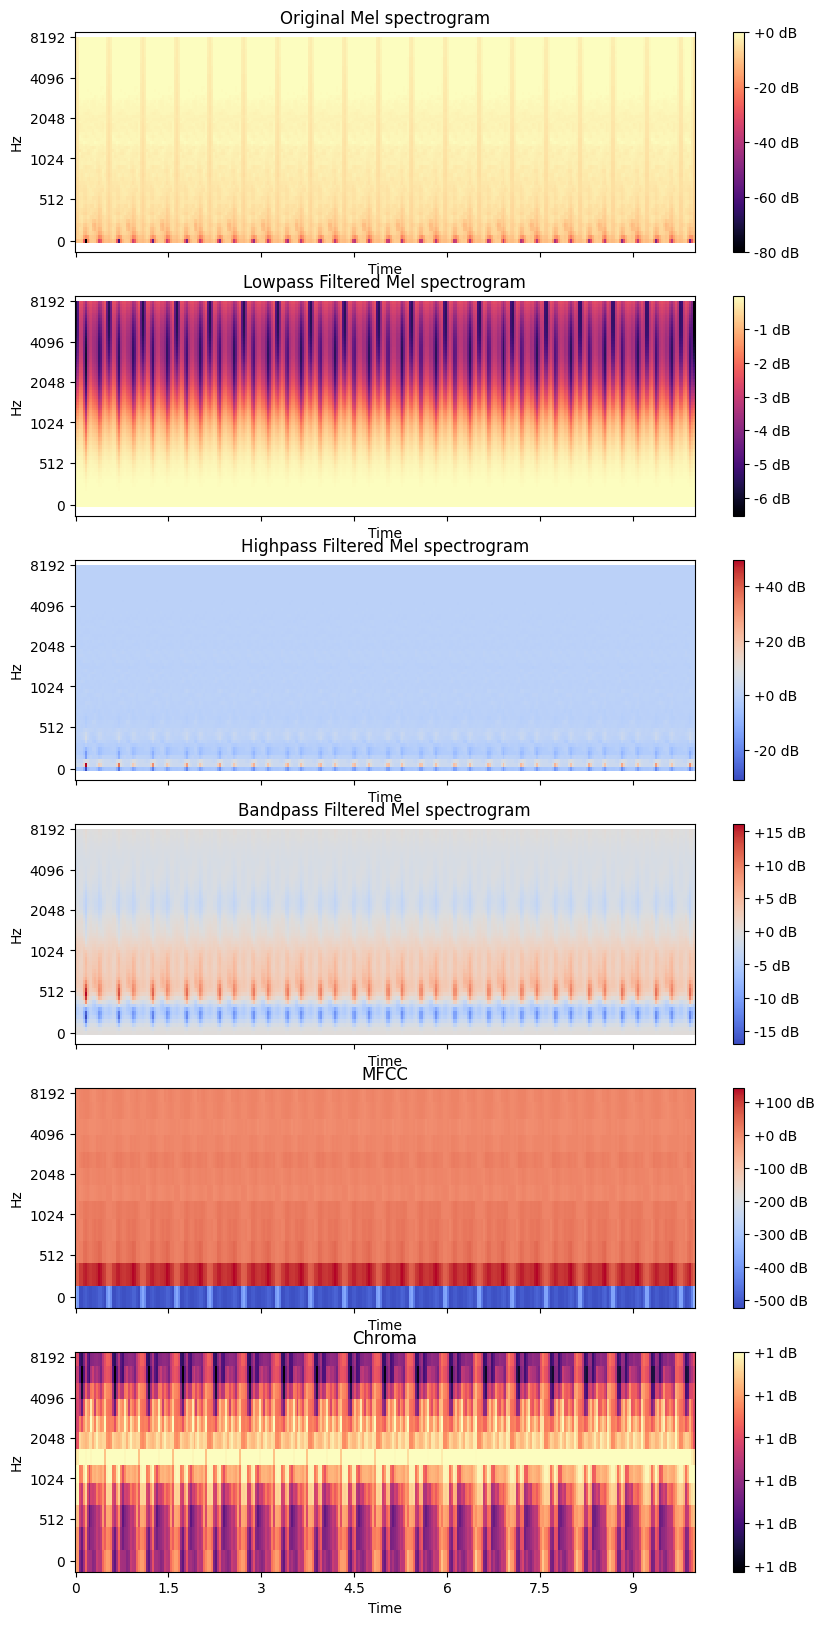

In [66]:
# Plot the original and filtered spectrograms
fig, ax = plt.subplots(nrows=6, sharex=True, sharey=True, figsize=(10, 20))

img = librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[0])
ax[0].set(title='Original Mel spectrogram')
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')

img = librosa.display.specshow(S_low_filtered, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Lowpass Filtered Mel spectrogram')
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

img = librosa.display.specshow(S_high_filtered, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[2])
ax[2].set(title='Highpass Filtered Mel spectrogram')
fig.colorbar(img, ax=ax[2], format='%+2.0f dB')

img = librosa.display.specshow(S_band_filtered, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[3])
ax[3].set(title='Bandpass Filtered Mel spectrogram')
fig.colorbar(img, ax=ax[3], format='%+2.0f dB')

img = librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[4])
ax[4].set(title='MFCC')
fig.colorbar(img, ax=ax[4], format='%+2.0f dB')

img = librosa.display.specshow(chroma_stft, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax[5])
ax[5].set(title='Chroma')
fig.colorbar(img, ax=ax[5], format='%+2.0f dB')

plt.show()

In [143]:
normal_feature_pool = np.empty([1,252])
crackle_feature_pool = np.empty([1,252])
wheeze_feature_pool = np.empty([1,252])
both_feature_pool = np.empty([1,252])

for index in tqdm(range(len(audio_data)), total=len(audio_data)):
    audio = audio_data[index][0]
    label = audio_data[index][1]


    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S = librosa.power_to_db(S, ref=np.max)
    S = (S-S.min()) / (S.max() - S.min())
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    #print("mel spectrogram shape: ", S.shape)


    # Apply Mel-Spectrogram Filter
    # Define filter parameters
    low_cutoff = 200  # Lowpass filter cutoff frequency (in Hz)
    high_cutoff = 1800  # Highpass filter cutoff frequency (in Hz)
    band_low_cutoff = 200  # Bandpass filter lower cutoff frequency (in Hz)
    band_high_cutoff = 1800  # Bandpass filter upper cutoff frequency (in Hz)

    # Calculate Nyquist frequency
    nyquist = 0.5 * sample_rate

    # Design filters
    low = low_cutoff / nyquist
    b_low, a_low = scipy.signal.butter(4, low, btype='low')

    high = high_cutoff / nyquist
    b_high, a_high = scipy.signal.butter(4, high, btype='high')

    low_band = band_low_cutoff / nyquist
    high_band = band_high_cutoff / nyquist
    b_band, a_band = scipy.signal.butter(4, [low_band, high_band], btype='band')

    # Apply filters to the Mel spectrogram
    def apply_filter(S, b, a):
        return scipy.signal.lfilter(b, a, S, axis=0)

    # Apply filters to each frequency bin in the Mel spectrogram
    S_low_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_low, a_low), 0, S_db)
    S_high_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_high, a_high), 0, S_db)
    S_band_filtered = np.apply_along_axis(lambda x: apply_filter(x, b_band, a_band), 0, S_db)

    # Stack the filtered spectrograms to form a 3D array
    S_filtered = np.stack((S_low_filtered, S_high_filtered, S_band_filtered), axis=-1)

    # Print the shape of the resulting array
    #print("mel filters shape: ", S_filtered.shape)  # Expected to be (13, 313, 3)

    # MFCC
    mfcc = librosa.feature.mfcc(S=S,n_mfcc=12)
    # Compute the frame-wise energy
    energy = np.sum(librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)**2, axis=0)
    mfcc_with_energy = np.vstack((mfcc, energy))
    # print("MFCC shape: ", mfcc.shape)
    # print("MFCC w/ energy shape: ", mfcc_with_energy.shape)

    # Extract chroma feature stft -> cqt
    chroma_stft = librosa.feature.chroma_stft(S=np.abs(S_db))
    # print("chroma shape: ", chroma_stft.shape)

    # Extract Features
    spectral_features = []
    mfcc_features = []
    chroma_features = []
    for s in [S_low_filtered, S_high_filtered, S_band_filtered]:
        spectral_centroid = librosa.feature.spectral_centroid(S=np.abs(s))
        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=np.abs(s))
        spectral_contrast = librosa.feature.spectral_contrast(S=np.abs(s))
        spectral_rolloff = librosa.feature.spectral_rolloff(S=np.abs(s))
        
        spectral_features.append(np.concatenate((compute_14_features(spectral_centroid), compute_14_features(spectral_bandwidth),
                                    compute_14_features(spectral_contrast),compute_14_features(spectral_rolloff)), axis=0))
        # print('spectral_features shape:', spectral_features.shape)
        # MFCC & Chroma for each filtered mel-spec
        mfcc = librosa.feature.mfcc(S=s,n_mfcc=12)
        
        energy = np.sum(librosa.feature.rms(y=audio, frame_length=2048, hop_length=512)**2, axis=0)
        mfcc_with_energy = np.vstack((mfcc, energy))
        chroma_stft = librosa.feature.chroma_stft(S=np.abs(s))

        mfcc_feature =  compute_14_features(mfcc_with_energy)
        chroma_stft_feature =  compute_14_features(chroma_stft)

        mfcc_features.append(mfcc_feature)
        chroma_features.append(chroma_stft_feature)
        
    total_spectral_features = np.concatenate((spectral_features[0],spectral_features[1],spectral_features[2]),axis=0)
    total_chroma_features = np.concatenate((chroma_features[0],chroma_features[1],chroma_features[2]), axis=0)
    total_mfcc_features = np.concatenate((mfcc_features[0],mfcc_features[1],mfcc_features[2]), axis=0)
    
    feature_vector=np.concatenate((total_chroma_features, total_spectral_features, total_mfcc_features), axis=0).reshape(1,252)
    if label == 0:
        normal_feature_pool=np.concatenate((normal_feature_pool,feature_vector), axis=0)
    elif label == 1:
        crackle_feature_pool=np.concatenate((crackle_feature_pool,feature_vector), axis=0)
    elif label == 2:
        wheeze_feature_pool=np.concatenate((wheeze_feature_pool,feature_vector), axis=0)
    else:
        both_feature_pool=np.concatenate((both_feature_pool,feature_vector), axis=0)
    

normal_feature_pool=np.delete(normal_feature_pool, 0, 0)
normal_feature_pool=np.concatenate((normal_feature_pool,0*np.ones(len(normal_feature_pool)).reshape(len(normal_feature_pool),1)), axis=1)#add label to the last column   

crackle_feature_pool=np.delete(crackle_feature_pool, 0, 0)
crackle_feature_pool=np.concatenate((crackle_feature_pool,1*np.ones(len(crackle_feature_pool)).reshape(len(crackle_feature_pool),1)), axis=1)#add label to the last column   

wheeze_feature_pool=np.delete(wheeze_feature_pool, 0, 0)
wheeze_feature_pool=np.concatenate((wheeze_feature_pool,2*np.ones(len(wheeze_feature_pool)).reshape(len(wheeze_feature_pool),1)), axis=1)#add label to the last column   

both_feature_pool=np.delete(both_feature_pool, 0, 0)
both_feature_pool=np.concatenate((both_feature_pool,3*np.ones(len(both_feature_pool)).reshape(len(both_feature_pool),1)), axis=1)#add label to the last column   

sio.savemat('normal' + '_252.mat', {'normal': feature_pool}) # save the created feature pool as a mat file 
sio.savemat('crackle' + '_252.mat', {'crackle': feature_pool}) # save the created feature pool as a mat file 
sio.savemat('wheeze' + '_252.mat', {'wheeze': feature_pool}) # save the created feature pool as a mat file 
sio.savemat('both' + '_252.mat', {'both': feature_pool}) # save the created feature pool as a mat file 


  0%|          | 0/14568 [00:00<?, ?it/s]

c:\Users\khsfu\anaconda3\envs\icbhi\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
  0%|          | 12/14568 [00:01<28:49,  8.42it/s] C:\Users\khsfu\AppData\Local\Temp\ipykernel_39980\2038705271.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Skewness = skew(all_pixels)
C:\Users\khsfu\AppData\Local\Temp\ipykernel_39980\2038705271.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Kurtosis = kurtosis(all_pixels)
100%|██████████| 14568/14568 [27:53<00:00,  8.70it/s]


In [108]:
source_dir= './'
normal_features=sio.loadmat(os.path.join(source_dir,'mat','normal_322.mat')) 
normal_features=normal_features['normal']

crackle_features=sio.loadmat(os.path.join(source_dir,'mat','crackle_322.mat')) 
crackle_features=crackle_features['crackle']

wheeze_features=sio.loadmat(os.path.join(source_dir,'mat','wheeze_322.mat')) 
wheeze_features=wheeze_features['wheeze']

both_features=sio.loadmat(os.path.join(source_dir,'mat','both_322.mat')) 
both_features=both_features['both']

In [111]:
source_dir= './'
old_normal_features=sio.loadmat(os.path.join(source_dir,'original_mat','normal_322.mat')) 
old_normal_features=old_normal_features['normal']

old_crackle_features=sio.loadmat(os.path.join(source_dir,'original_mat','crackle_322.mat')) 
old_crackle_features=old_crackle_features['crackle']

old_wheeze_features=sio.loadmat(os.path.join(source_dir,'original_mat','wheeze_322.mat')) 
old_wheeze_features=old_wheeze_features['wheeze']

old_both_features=sio.loadmat(os.path.join(source_dir,'original_mat','both_322.mat')) 
old_both_features=old_both_features['both']  

In [144]:
source_dir= './'
new_normal_features=sio.loadmat(os.path.join(source_dir,'mat252','normal_252.mat')) 
new_normal_features=new_normal_features['normal']

new_crackle_features=sio.loadmat(os.path.join(source_dir,'mat252','crackle_252.mat')) 
new_crackle_features=new_crackle_features['crackle']

new_wheeze_features=sio.loadmat(os.path.join(source_dir,'mat252','wheeze_252.mat')) 
new_wheeze_features=new_wheeze_features['wheeze']

new_both_features=sio.loadmat(os.path.join(source_dir,'mat252','both_252.mat')) 
new_both_features=new_both_features['both']  

In [145]:
print(normal_features.shape)
print(old_both_features.shape)
print(new_normal_features.shape)

(3642, 85)
(3642, 323)
(2, 252)


In [132]:
np.isnan(both_features).sum()

4

In [3]:
import librosa
data, rate = librosa.load('ICBHI_Dataset/audio_and_txt_files/107_2b3_Ar_mc_AKGC417L.wav', sr=16000)
print(data)

[0.        0.        0.        ... 0.8259391 0.778538  0.8544273]


In [16]:
import gradio as gr
import numpy as np

example_files = [
    "ICBHI_Dataset/audio_and_txt_files/104_1b1_Al_sc_Litt3200",
    "ICBHI_Dataset/audio_and_txt_files/107_2b3_Ll_mc_AKGC417L",
    "ICBHI_Dataset/audio_and_txt_files/221_2b1_Pl_mc_LittC2SE",
    "ICBHI_Dataset/audio_and_txt_files/107_2b3_Ar_mc_AKGC417L",    
    "ICBHI_Dataset/audio_and_txt_files/110_1p1_Al_sc_Meditron",    
]



In [17]:
import os
import numpy as np
import librosa
import soundfile as sf

# temp.txt 파일을 읽어 시작 시간과 종료 시간을 가져오는 함수
def read_intervals(file_path):
    intervals = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            start_time = float(parts[0])
            end_time = float(parts[1])
            intervals.append((start_time, end_time))
    return intervals

# temp.wav 파일에서 주어진 구간을 잘라서 저장하는 함수
def split_and_save_audio(audio_path, intervals, output_dir, sample_rate=16000):
    # 오디오 파일 로드
    data, rate = librosa.load(audio_path, sr=sample_rate)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 각 구간을 잘라서 저장
    for i, (start_time, end_time) in enumerate(intervals):
        start_sample = int(start_time * rate)
        end_sample = int(end_time * rate)
        segment = data[start_sample:end_sample]
        filename = audio_path.split('/')[-1].split('.')[0]
        print(filename)
        output_file = os.path.join(output_dir, f'{filename}_segment_{i + 1}.wav')
        sf.write(output_file, segment, rate)
        print(f'Saved {output_file}')

output_directory = 'output_segments'
# 경로 설정
for i in example_files:
    txt_file_path = i+'.txt'
    wav_file_path = i+'.wav'

    # 구간 읽기
    intervals = read_intervals(txt_file_path)

    # 오디오 파일 분할 및 저장
    split_and_save_audio(wav_file_path, intervals, output_directory)


104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_1.wav
104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_2.wav
104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_3.wav
104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_4.wav
104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_5.wav
104_1b1_Al_sc_Litt3200
Saved output_segments\104_1b1_Al_sc_Litt3200_segment_6.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_1.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_2.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_3.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_4.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_5.wav
107_2b3_Ll_mc_AKGC417L
Saved output_segments\107_2b3_Ll_mc_AKGC417L_segment_6.wav
107_2b3_Ll_mc_AK

## HF Lung Parsing

In [1]:
import librosa
import soundfile as sf

def time_to_seconds(time_str):
    h, m, s = map(float, time_str.split(':'))
    return h * 3600 + m * 60 + s

def process_audio_segments(audio_path, txt_path, output_prefix):
    # 오디오 파일 로드
    y, sr = librosa.load(audio_path, sr=None)

    # 텍스트 파일 파싱
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    index = 0
    for line in lines:
        label, start_time, end_time = line.strip().split()
        start_sec = time_to_seconds(start_time)
        end_sec = time_to_seconds(end_time)
        
        # 오디오 자르기
        start_sample = int(start_sec * sr)
        end_sample = int(end_sec * sr)
        audio_segment = y[start_sample:end_sample]

        # 새 파일명 생성
        output_filename = f"{label}_{output_prefix}_{index}.wav"
        
        # 오디오 파일 저장
        sf.write(output_filename, audio_segment, sr)
        
        index += 1



In [8]:
# 사용 예시
filename = 'HF_Lung_V1//test_4000//trunc_2019-08-21-11-39-26-L6_10'
audio_file = filename+'.wav'
output_prefix = 'output_segments//hf_lung_segments//'+filename.split('//')[-1]
txt_file = filename+'_label'+'.txt'

process_audio_segments(audio_file, txt_file, output_prefix)
